# **CS5658 Anomaly Detection Homework3 – Industrial Anomaly Detection**

## Due Date:  5/2 23:30

#### MVTec AD dataset
MVTec AD is a benchmark dataset for industrial anomaly detection tasks. It contains 15 industrial product classes with over 5000 images in total. The dataset is designed to perform image anomaly detection and segmentation tasks. There are normal / defect images for each class, with ground truth masks provided for the defect samples.


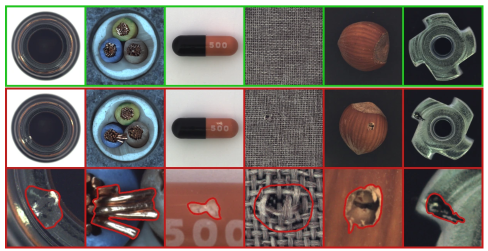

### SimpleNet
SimpleNet is a deep learning model proposed in CVPR 2023. It trains a simple MLP by classifying noisy features from normal features and using it as a discriminator to classify whether a feature is anomaly or not.

Reference: SimpleNet, CVPR 2023

Paper: https://openaccess.thecvf.com/content/CVPR2023/papers/Liu_SimpleNet_A_Simple_Network_for_Image_Anomaly_Detection_and_Localization_CVPR_2023_paper.pdf

Github: https://github.com/DonaldRR/SimpleNet

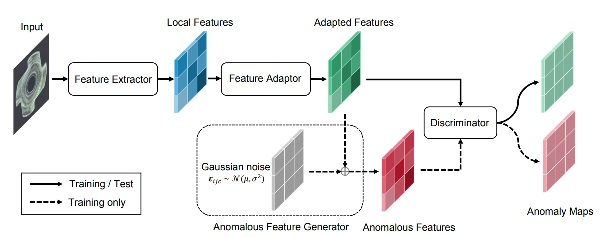


# Problem Setting
In this homework, we will choose two classes in MVTecAD: `metal_nut` and `leather` to perform anomaly detection and segmentation task. You need to implement SimpleNet method by your own, then inference on the two classes. We will use SimpleNet as our architecture, but for the simplicity and training speed, we've made a little adjustments.

* Ignore average pooling in constructing multi-scale feature map
* Use layers [2,3] of WideResNet50
* Epoch reduced from 40 to 20
* Ignore learning rate scheduler
* Discriminator outputs anomaly score instead of normal score

Please implement adaptor and discriminator using the assigned learning rate as follow.
```
adaptor_lr = 1e-3
discriminator_lr = 2e-4
```

Please use **pretrained WideResNet 50** as your feature extractor.

# 1.Download Dataset

In [ ]:
# ! gdown 1vFb_AWIK6nh8BRhRQLM96q2nUqPHsdAR
# ! unzip mvtec.zip

# 2.Prepare Environment

1.Install needed modules

In [ ]:
# ! pip install einops

2.Import needed modules and set random seed to ensure that results
are consistent every time executed.

In [ ]:
from torchvision.models import wide_resnet50_2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
from einops import rearrange
from tqdm.notebook import tqdm
import os
from sklearn.preprocessing import minmax_scale


#########################################
# prepare environment
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

seed_everything(9999)

# 3.Prepare Dataset

In [ ]:
#######################################
# prepare dataset
# import torchvision.transforms as transforms
class_names = ['leather', 'metal_nut']
class MVTecDataset(Dataset):
    def __init__(self, mvtec_folder_path='./mvtec', class_name=class_names, is_train=True,
                 few_shot=219,resize=256): #
        self.class_name = class_name
        self.is_train = is_train
        self.resize = resize
        self.mvtec_folder_path = mvtec_folder_path
        self.few_shot = few_shot
        # self.transform = transform
        # set transforms
        self.transform_x = T.Compose([T.Resize(resize,interpolation=T.InterpolationMode.BILINEAR),
                                    #   transforms.RandomResizedCrop(224),
                                    #     transforms.RandomHorizontalFlip(),
                                    #     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, interpolation=T.InterpolationMode.NEAREST),
                                        # transforms.Resize(256),
                                        # transforms.CenterCrop(224),
                                         T.ToTensor()])
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        phase = 'training' if self.is_train else 'testing'
        print(f"{self.class_name} {phase} dataset created, consists of {len(self.x)} images")


    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, phase)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')
        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            # load images
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)
            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png')
                                 for img_fname in img_fname_list]
                mask.extend(gt_fpath_list)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.few_shot is not None and phase=='train':
            # pick images according to few_shot number
            chosen_idx = random.sample(list(range(len(x))),k=self.few_shot)
            x = [x[i] for i in chosen_idx]
            y = [y[i] for i in chosen_idx]
            mask = [mask[i] for i in chosen_idx]

        return [self.transform_x(Image.open(x).convert('RGB')).cuda() for x in list(x)], \
                list(y), \
                [torch.zeros([1, self.resize, self.resize]).cuda() if y==0 else self.transform_mask(Image.open(mask)).cuda() for y,mask in zip(list(y),list(mask))]



# 4.Load & Prepare Feature Extractor

In [ ]:

#######################################
# load & prepare model (wide_resnet50_2)
encoder = wide_resnet50_2(pretrained=True, progress=True).cuda()
encoder.eval()
# set hook function to get features
outputs = list()
def hook(module, input, output):
    outputs.append(output)

def get_features(model,img,outputs):
    with torch.no_grad():
            _ = model(img.cuda())
    layer1_feature = outputs[0]
    layer2_feature = outputs[1]
    layer3_feature = outputs[2]
    outputs.clear()
    return [layer1_feature,layer2_feature,layer3_feature]

encoder.layer1.register_forward_hook(hook)
encoder.layer2.register_forward_hook(hook)
encoder.layer3.register_forward_hook(hook)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 5.Define Our Function to Produce Multi-Scale Feature Map (TODO Q1)

## TODO Q1
In this section, you need to produce multi-scale feature map in this function.</br></br>
The procedure is listed below:</br>
1. Choose a size to resize to, for example, size of second layers as our target size.</br>
1. Resize all features to the target size and store them.</br>
1. Concatenate them all together and return the result.</br>

You need to finish the step2 above, that is, resize `features[i]` to the target size and assign to `temp_feature`.</br>
For example, if the `target_size` is 32, and `features[i]` have size `(batch, channel, width, height)`, the `temp_feature` should have size `(batch, channel, 32, 32)`




In [ ]:
import torch.nn.functional as F
#######################################
# produce multi-scale feature
def concat_feature(features,use_layers=None):
    use_layers = [i-1 for i in use_layers]
    # determine resize to which feature
    target_size = features[1].size()[3] # 32
    resized_feature = list()

    for i in range(len(features)):
        current_size = features[i].size()[3]

        ## TODO ######################################################
        # please calculate the factor or size to resize to
        # use F.interpolate() to resize, set mode to bilinear
        # align_corners to False.
        # For more instruction, please refer to :
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html

        # Calculate the factor or size to resize to
        resize_factor = target_size / current_size
        # Use F.interpolate() to resize, set mode to bilinear, align_corners to False
        temp_feature = F.interpolate(features[i], scale_factor=resize_factor, mode='bilinear', align_corners=False)

        #############################################################
        resized_feature.append(temp_feature)

    return torch.concat([resized_feature[i] for i in use_layers],dim=1)

# 6.Define The Adaptor & Discriminator Of Our Model (TODO Q2)

## TODO Q2
- In this section, you need to design a MLP as the Adaptor.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `out_channel` as its channel dimention.</br>
- Implement **the same Adaptor** in SimpleNet paper.
NOTE: the MLP should not be very complex, you can design a simple one, check the result, and determine if it needs to be more complex. </br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. your image-AUC of both classes must be greater than 0.8.</br>
***layers = Linear -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension, add Dropout layer, etc. </br>

In [ ]:
# Implement the same Adaptor in SimpleNet
import torchvision.transforms as transforms
def init_weight(m):

    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
    elif isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)

class MLPAdaptor(torch.nn.Module):

    def __init__(self, in_planes, out_planes=None, n_layers=1, layer_type=0): #
        super(MLPAdaptor, self).__init__()

        if out_planes is None:
            out_planes = in_planes
        self.layers = torch.nn.Sequential(nn.Linear(in_planes, 256),
                                        nn.LeakyReLU(0.2),
                                        nn.Linear(256, 512),
                                        nn.LeakyReLU(0.2),
                                        nn.Linear(512, 1024),
                                        nn.LeakyReLU(0.2),
                                        nn.Linear(1024, 512),
                                        nn.LeakyReLU(0.2),
                                        nn.Linear(512, 256),
                                        nn.Linear(256, out_planes),
                                        nn.Dropout(0.2),
        )


        _in = None
        _out = None
        for i in range(n_layers):
            _in = in_planes if i == 0 else _out
            _out = out_planes
            # print("out")
            # print(_out)
            self.layers.add_module(f"{i}fc",
                        torch.nn.Linear(_in, _out))
            if i < n_layers - 1:
                if layer_type > 0:
                    self.layers.add_module(f"{i}bn",
                                           torch.nn.BatchNorm1d(_out))
                if layer_type > 1:
                    self.layers.add_module(f"{i}relu",
                                torch.nn.LeakyReLU(0.2))

        self.apply(init_weight)

    def forward(self, x):
        x = .1 * self.layers(x) + x
        x = self.layers(x)
        return x

- In this section, you need to design a MLP as the Discriminator's body.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `mid_channel` as its channel dimention.</br>
- First, implement **the same Discriminator** in SimpleNet paper.
- Second, design your own version of Discriminator with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the Discriminator should involve at least one BatchNormalization layer.</br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. It's OK to get lower score than default, but image-AUC of both classes must be greater than 0.8.</br>
***Body = Linear -> BatchNorm1d -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension (`mid_channel`), add Dropout layer, etc. </br>


In [ ]:
# Implement the same Discriminator in SimpleNet

class SimpleNetDiscriminator(nn.Module):
    def __init__(self, in_planes, n_layers=2, hidden=None):
        super(SimpleNetDiscriminator, self).__init__()

        _hidden = in_planes if hidden is None else hidden
        # _mid_channels = in_planes // 2 if mid_channels is None else mid_channels


        self.body = nn.Sequential()
        for i in range(n_layers-1):
            _in = in_planes if i == 0 else _hidden
            _hidden = int(_hidden // 9) if hidden is None else hidden #

            self.body.add_module('block%d'%(i+1),
                      nn.Sequential(
                        nn.Linear(_in,_hidden),
                        # nn.LeakyReLU(0.2),
                        # nn.Linear(512, 1024),
                        # nn.LeakyReLU(0.2),
                        # nn.Linear(1024, 512),
                        # nn.LeakyReLU(0.2),
                        # nn.Linear(512, 256),
                        # nn.Linear(256, _hidden),
                        nn.BatchNorm1d(_hidden),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.2)
                     ))
        self.tail = nn.Linear(_hidden, 1, bias=False)
        self.apply(init_weight)

    def forward(self,x):
        x = self.body(x)
        x = self.tail(x)
        return x


# Implement your own Discriminator with fewer model parameters

# Reduced hidden dimension:
# Decrease the hidden dimension in each layer to reduce the number of parameters.
# class ReducedHiddenDiscriminator(nn.Module):
#     def __init__(self, in_planes, n_layers=1, hidden=None):
#         super(ReducedHiddenDiscriminator, self).__init__()

#         _hidden = in_planes if hidden is None else hidden
#         self.body = nn.Sequential()
#         for i in range(n_layers-1):
#             _in = in_planes if i == 0 else _hidden
#             _hidden = int(_hidden // 8) if hidden is None else hidden
#             self.body.add_module('block%d'%(i+1),
#                                  nn.Sequential(
#                                      nn.Linear(_in, _hidden),
#                                      nn.BatchNorm1d(_hidden),
#                                      nn.LeakyReLU(0.8)
#                                  ))
#         self.tail = nn.Linear(_hidden, 1, bias=False)
#         self.apply(init_weight)

#     def forward(self,x):
#         x = self.body(x)
#         x = self.tail(x)
#         return x

# # Reduced number of layers:
# # Decrease the number of layers while keeping the hidden dimension the same to reduce the number of parameters.
# class ReducedLayersDiscriminator(nn.Module):
#     def __init__(self, in_planes, n_layers=1, hidden=None):
#         super(ReducedLayersDiscriminator, self).__init__()

#         _hidden = in_planes if hidden is None else hidden
#         self.body = nn.Sequential()
#         for i in range(n_layers//2):
#             _in = in_planes if i == 0 else _hidden
#             self.body.add_module('block%d'%(i+1),
#                                  nn.Sequential(
#                                      nn.Linear(_in, _hidden),
#                                      nn.BatchNorm1d(_hidden),
#                                      nn.LeakyReLU(0.2)
#                                  ))
#         self.tail = nn.Linear(_hidden, 1, bias=False)
#         self.apply(init_weight)

#     def forward(self,x):
#         x = self.body(x)
#         x = self.tail(x)
#         return x


# 7.Define Our Whole Model (SimpleNet)

In [ ]:
#######################################
# define our model (simplenet)
class Simplenet(nn.Module):
    def __init__(self,in_channel):
        super(Simplenet,self).__init__()
        self.features = nn.Sequential()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.adaptor = MLPAdaptor(in_channel,in_channel)
        self.discriminator = SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=512) #


    def add_noise(self,true_feats):
        # noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_idxs = torch.randint(0, 1, (true_feats.shape[0],)).cuda()
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)

        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    # def forward(self,x):
    #     true_feats = self.adaptor(x)
    #     fake_feats = self.add_noise(true_feats)
    #     scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
    #     return scores

    # def predict(self,x):
    #     true_feats = self.adaptor(x)
    #     scores = self.discriminator(true_feats)
    #     return scores,true_feats

    def forward(self,features):

        batch_size, channels, height, width = features.size()
        K = batch_size * height * width
        C = channels
        features = features.view(K, C)

        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 16 * 5 * 5)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.mlp_adaptor(x)

        features = self.adaptor(features)
        fake_feats = self.add_noise(features)
        scores = self.discriminator(torch.cat([features, fake_feats], dim=0))

        return scores

    def predict(self,features):

        batch_size, channels, height, width = features.size()
        K = batch_size * height * width
        C = channels
        features = features.view(K, C)

        features = self.adaptor(features)
        scores = self.discriminator(features)

        return scores, features

# 8.Define The Training Process

In [ ]:
def train_one_epoch(encoder,simplenet,adaptor_optim,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0

    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)

        scores = simplenet(features)
        true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 #margin
        true_loss = torch.clip(true_scores + th, min=0)
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = true_loss.mean() + fake_loss.mean()
        total_loss+=loss

        # clear gradient
        adaptor_optim.zero_grad()
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        adaptor_optim.step()
        discriminator_optim.step()
    return total_loss

# 9.Define The Testing Process

In [ ]:
#######################################
# testing
@torch.no_grad()
def test(encoder,simplenet,dataset,use_layers,batch_size):
    result = dict()
    result['total_scores_pixel'] = list()
    result['total_scores_image'] = list()
    result['total_gt_pixel'] = list()
    result['total_gt_image'] = list()
    result['features_orig'] = list()
    result['features_adapted'] = list()
    result['input_image'] = list()


    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        simplenet.eval()
        # store input image
        result['input_image'].append(x.cpu().detach().numpy())
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        # store features before adaptor
        result['features_orig'].append(rearrange(features,'b c h w -> (b h w) c').cpu().detach().numpy())
        size = features.size()
        scores,true_feats = simplenet.predict(features)
        # store features after adaptor
        result['features_adapted'].append(true_feats.cpu().detach().numpy())

        # calculate and store image-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b (h w)',b=size[0],h=size[3],w=size[2])
        image_score,_ = torch.max(anomaly_score_map,dim=1,keepdim=False)
        result['total_scores_image'].append(image_score.cpu().detach().numpy())

        # calculate and store pixel-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b 1 h w',b=size[0],h=size[3],w=size[2])
        anomaly_score_map = F.interpolate(anomaly_score_map,
                                        size=(x.size()[2],x.size()[3]),
                                        mode="bilinear",
                                        align_corners=False)
        anomaly_score_1d = rearrange(anomaly_score_map,'b c h w -> (b c h w)')
        result['total_scores_pixel'].append(anomaly_score_1d.cpu().detach().numpy())

        # store groundtruth
        mask_1d = rearrange(mask,'b c h w -> (b c h w)')
        result['total_gt_pixel'].append(mask_1d.cpu().detach().numpy())
        result['total_gt_image'].append(y.cpu().detach().numpy())

    # gether all scores and groundtruth
    result['input_image'] = np.concatenate(result['input_image'],axis=0)
    result['total_scores_pixel'] = np.hstack(result['total_scores_pixel'])
    result['total_scores_image'] = np.hstack(result['total_scores_image'])
    result['total_gt_pixel'] = np.hstack(result['total_gt_pixel'])
    result['total_gt_image'] = np.hstack(result['total_gt_image'])

    # gether all extracted features
    result['features_orig'] = np.concatenate(result['features_orig'],axis=0)
    result['features_adapted'] = np.concatenate(result['features_adapted'],axis=0)

    # min-max normalization on scores
    result['total_scores_pixel'] = minmax_scale(result['total_scores_pixel'])
    result['total_scores_image'] = minmax_scale(result['total_scores_image'])

    simplenet.train()
    return result

# 10.Define Functions That Calculate And Show ROC & AUROC (TODO Q3)

## TODO Q3
In this section, you need to define the function to calculate false-positive rate, true-positive rate and area-under ROC by the scores and the groundtruth labels and assign them to `fpr`, `tpr`, `auc` respectively.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def calculate_roc(scores, labels):
    fpr, tpr, _ = roc_curve(labels, scores)
    auc = roc_auc_score(labels,scores)
    return fpr, tpr, auc

# 11.Define Other Utility Functions (if Needed)

# 12.Setup Training Parameters

Setup learning rate, total epoch, layers to used, SimpleNet and optimizer for both class.

In [ ]:
# Training parameters
adaptor_lr = 1e-3
discriminator_lr = 2e-4
epochs = 20

# Define use_layers
use_layers = [2]


# Create SimpleNet and optimizer for both classes
import torch.optim as optim
simple_net = Simplenet(in_channel=512).cuda()
adaptor_params = simple_net.adaptor.parameters()
discriminator_params = simple_net.discriminator.parameters()
adaptor_optim = optim.Adam(adaptor_params, lr=adaptor_lr)
discriminator_optim = optim.Adam(discriminator_params, lr=discriminator_lr)


# Create datasets for both classes
leather_train_dataset = MVTecDataset(mvtec_folder_path='./mvtec', class_name='leather', is_train=True)
leather_test_dataset = MVTecDataset(mvtec_folder_path='./mvtec', class_name='leather', is_train=False)
metal_train_dataset = MVTecDataset(mvtec_folder_path='./mvtec', class_name='metal_nut', is_train=True)
metal_test_dataset = MVTecDataset(mvtec_folder_path='./mvtec', class_name='metal_nut', is_train=False)




leather training dataset created, consists of 219 images
leather testing dataset created, consists of 124 images
metal_nut training dataset created, consists of 219 images
metal_nut testing dataset created, consists of 115 images


# 13.Start Training & Testing (TODO Q4)

## TODO Q4
Write your training / testing code and plot ROC curve.

In [ ]:
import matplotlib.pyplot as plt
# Training and testing loop
for epoch in range(epochs):
    # Train the model
    loss = train_one_epoch(encoder, simple_net, adaptor_optim, discriminator_optim, leather_train_dataset, use_layers, batch_size=4)
    print(f"Epoch {epoch+1}/{epochs}, leather loss: {loss.item()}")

    # Test the model
    result = test(encoder, simple_net, leather_test_dataset, use_layers, batch_size=4)

for epoch in range(epochs):
    # Train the model
    loss = train_one_epoch(encoder, simple_net, adaptor_optim, discriminator_optim, metal_train_dataset, use_layers, batch_size=4)
    print(f"Epoch {epoch+1}/{epochs}, metal_nut loss: {loss.item()}")

    # Test the model
    result1 = test(encoder, simple_net, metal_test_dataset, use_layers, batch_size=4)

Epoch 1/20, leather loss: 42.5554313659668
Epoch 2/20, leather loss: 2.5359749794006348
Epoch 3/20, leather loss: 0.859731137752533
Epoch 4/20, leather loss: 0.5294216871261597
Epoch 5/20, leather loss: 0.3077973425388336
Epoch 6/20, leather loss: 0.10413108766078949
Epoch 7/20, leather loss: 0.06034428998827934
Epoch 8/20, leather loss: 0.039459750056266785
Epoch 9/20, leather loss: 0.027382701635360718
Epoch 10/20, leather loss: 0.022998502478003502
Epoch 11/20, leather loss: 0.019017694517970085
Epoch 12/20, leather loss: 0.015529375523328781
Epoch 13/20, leather loss: 0.016584953293204308
Epoch 14/20, leather loss: 0.01160967256873846
Epoch 15/20, leather loss: 0.01044885441660881
Epoch 16/20, leather loss: 0.008261456154286861
Epoch 17/20, leather loss: 0.005932692438364029
Epoch 18/20, leather loss: 0.007019361946731806
Epoch 19/20, leather loss: 0.006571554578840733
Epoch 20/20, leather loss: 0.004967395216226578
Epoch 1/20, metal_nut loss: 56.87845993041992
Epoch 2/20, metal_nu

Calculate & Plot ROC curve

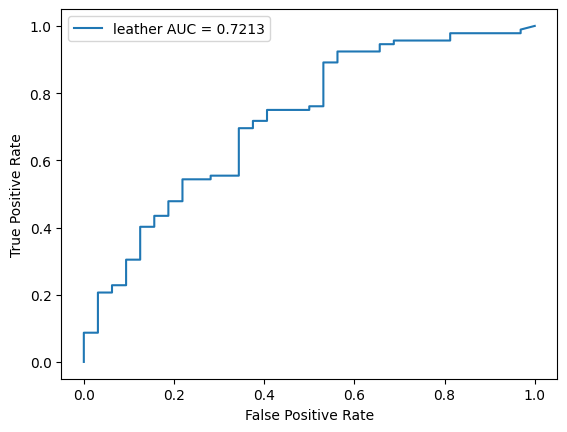

In [ ]:
fpr, tpr, auc_score = calculate_roc(result['total_scores_image'] ,result['total_gt_image'])

# Plot ROC curve
plt.plot(fpr, tpr, label=f'leather AUC = {auc_score:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


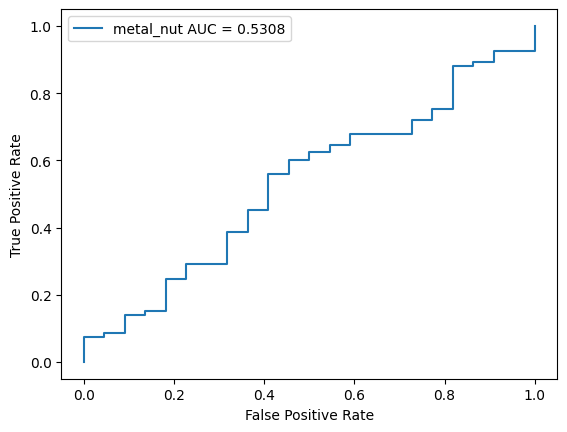

In [ ]:
fpr, tpr, auc_score = calculate_roc(result1['total_scores_image'] ,result1['total_gt_image'],)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'metal_nut AUC = {auc_score:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# 15.Plot Parameters-ROC Figure (TODO Q5)


## TODO Q5
* Try different number of parameters in Discriminator, record the performance.
* Plot the figure with `X-axis=Number of SimpleNet Params`, `Y-axis=AUROC Performance`
* Mark the original SimpleNet as `black point`.
* Mark your models with different number of parameters as `blue points`.


In [ ]:
# Use the following code to measure your model parameters

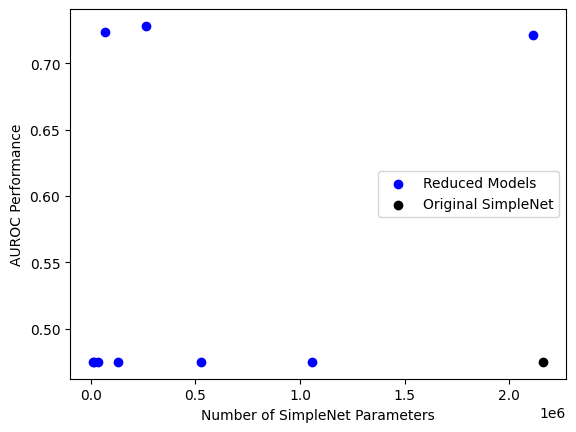

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of parameters in the original SimpleNet
num_params_original = sum(p.numel() for p in simple_net.parameters())

# Create a list of models with different number of parameters in the discriminator
models = [
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=16),  # 16 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=32),  # 32 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=64),  # 64 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=128),  # 128 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=256), # 256 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=512),
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=1024),
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=2048),
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=4096)
]

# Calculate the number of parameters for each model
num_params = [sum(p.numel() for p in model.parameters()) for model in models]

# Test each model and record the AUROC performance
auroc_scores = []
for model in models:
    simple_net.discriminator = model.cuda()
    result = test(encoder, simple_net, leather_test_dataset, use_layers, batch_size=16)
    fpr, tpr, auc_score = calculate_roc(result['total_scores_image'], result['total_gt_image'])
    auroc_scores.append(auc_score)

# Plot the figure
plt.scatter(num_params, auroc_scores, color='blue', label='Reduced Models')
plt.scatter(num_params_original, auroc_scores[0], color='black', label='Original SimpleNet')
plt.xlabel('Number of SimpleNet Parameters')
plt.ylabel('AUROC Performance')
plt.legend()
plt.show()



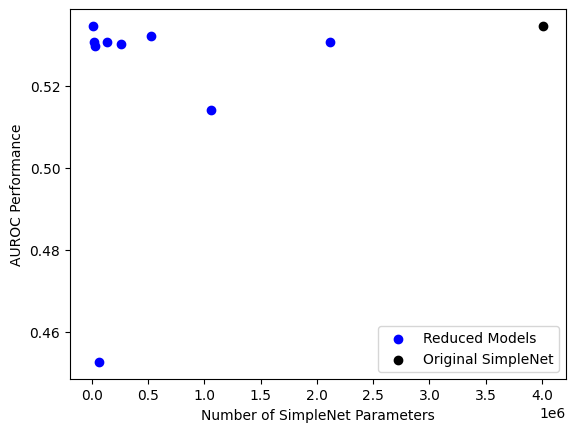

In [ ]:
# Calculate the number of parameters in the original SimpleNet
num_params_original = sum(p.numel() for p in simple_net.parameters())

# Create a list of models with different number of parameters in the discriminator
models = [
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=16),  # 16 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=32),  # 32 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=64),  # 64 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=128),  # 128 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=256), # 256 parameters
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=512),
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=1024),
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=2048),
    SimpleNetDiscriminator(in_planes=512, n_layers=2, hidden=4096)
]

# Calculate the number of parameters for each model
num_params = [sum(p.numel() for p in model.parameters()) for model in models]

auroc_scores = []
for model in models:
    simple_net.discriminator = model.cuda()
    result1 = test(encoder, simple_net, metal_test_dataset, use_layers, batch_size=16)
    fpr, tpr, auc_score = calculate_roc(result1['total_scores_image'], result1['total_gt_image'])
    auroc_scores.append(auc_score)

# Plot the figure
plt.scatter(num_params, auroc_scores, color='blue', label='Reduced Models')
plt.scatter(num_params_original, auroc_scores[0], color='black', label='Original SimpleNet')
plt.xlabel('Number of SimpleNet Parameters')
plt.ylabel('AUROC Performance')
plt.legend()
plt.show()

# 15.Show Testing Results (Input & GT mask & anomaly map) (TODO Q6)

## TODO Q6
In this section, you need to choose a threshold for both class to produce a mask from anomaly map, a pixel with a score higher than the threshold is considered as anomaly region. Threshold should be a number between 0 and 1.

Random choose one inference mask for each class and output results.

(Testing Input / Ground Truth Mask / Predict Mask)

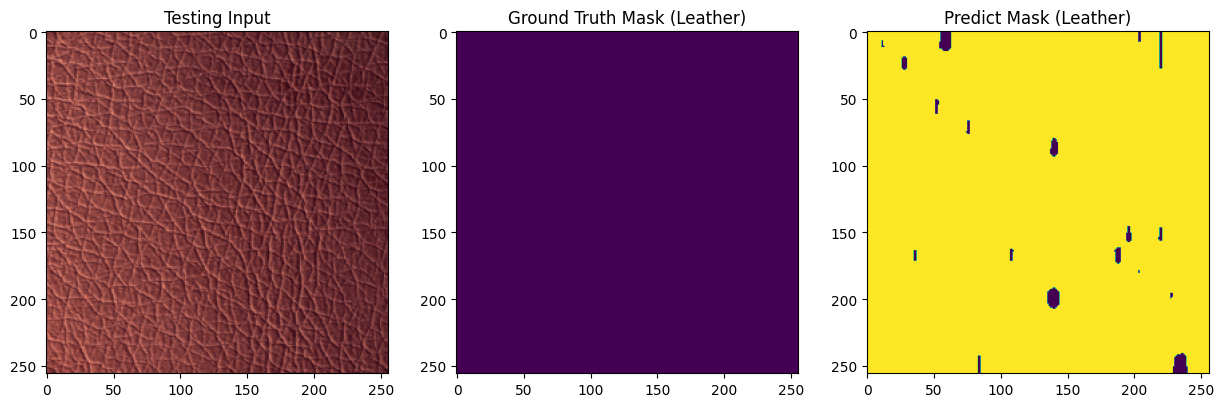

In [ ]:
# Define the threshold for both classes
threshold_leather = 0.5
# threshold_metal_nut = 0.6

# Randomly choose one inference mask for each class
idx = np.random.randint(len(result['input_image']))

# Get the input image, ground truth mask, and predicted mask for the selected class
input_image = result['input_image'][idx].T

# Find min and max values of input_image
min_value = np.min(input_image)
max_value = np.max(input_image)

# Normalize input_image to range [0, 1]
input_image = (input_image - min_value) / (max_value - min_value)

# gt_mask_leather_ = result['total_gt_image'][idx].T
# pred_mask_leather = (result['total_scores_image'][idx].T > threshold_leather)

gt_mask_leather_idx = 256*256*(idx + 1)
gt_mask_leather = 256*256*(idx)

def mask_transform(array, threshold):
    masked_array = (array > threshold).astype(int)
    return masked_array

gt_mask_leather_img = result['total_gt_pixel'][gt_mask_leather:gt_mask_leather_idx].T
gt_mask_leather_img = mask_transform(gt_mask_leather_img, threshold_leather)
gt_mask_leather_img = gt_mask_leather_img.reshape((256,256), order='F')

pred_mask_leather = result['total_scores_pixel'][gt_mask_leather:gt_mask_leather_idx].T
pred_mask_leather = mask_transform(pred_mask_leather, threshold_leather)
pred_mask_leather = pred_mask_leather.reshape((256,256), order='F')

# gt_mask_metal_nut = result['total_gt_image'][idx]
# pred_mask_metal_nut = (result['total_scores_image'][idx] > threshold_metal_nut).astype(int)

# input_image = np.transpose(input_image, (1, 0, 2))

# gt_mask_leather = np.transpose(gt_mask_leather, (1,0))
# pred_mask_leather = np.transpose(pred_mask_leather, (1,0))


# Plot the results
# print(input_image.shape)
# print(gt_mask_leather)
# print(pred_mask_leather.shape)

plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.imshow(input_image)
plt.title('Testing Input')

plt.subplot(1,3,2)
plt.imshow(gt_mask_leather_img)
plt.title('Ground Truth Mask (Leather)')

plt.subplot(1,3,3)
plt.imshow(pred_mask_leather)
plt.title('Predict Mask (Leather)')

plt.show()


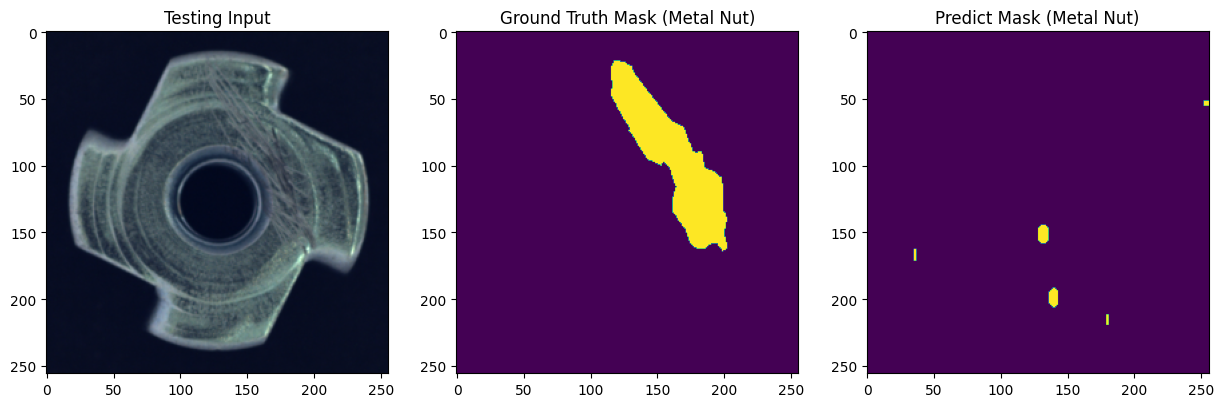

In [ ]:
# Define the threshold for both classes
threshold_metal_nut = 0.6

# Randomly choose one inference mask for each class
idx = np.random.randint(len(result1['input_image']))

# print(result['input_image'].shape)

# Get the input image, ground truth mask, and predicted mask for the selected class
input_image = result1['input_image'][idx].T
# input_image = np.flip(input_image, axis=(0, 1))

# Find min and max values of input_image
min_value = np.min(input_image)
max_value = np.max(input_image)

# Normalize input_image to range [0, 1]
input_image = (input_image - min_value) / (max_value - min_value)

gt_mask_metal = result1['total_gt_image'][idx].T

gt_mask_metal_idx = 256*256*(idx + 1)
gt_mask_metal = 256*256*(idx)

def mask_transform(array, threshold):
    masked_array = (array > threshold).astype(int)
    return masked_array

gt_mask_metal_img = result1['total_gt_pixel'][gt_mask_metal:gt_mask_metal_idx]
gt_mask_metal_img = mask_transform(gt_mask_metal_img, threshold_metal_nut)
gt_mask_metal_img = gt_mask_metal_img.reshape((256,256), order='F')

pred_mask_metal = result1['total_scores_pixel'][gt_mask_metal:gt_mask_metal_idx]
pred_mask_metal = mask_transform(pred_mask_metal, threshold_metal_nut)
pred_mask_metal = pred_mask_metal.reshape((256,256), order='F')

# input_image = np.transpose(input_image, (1, 0, 2))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Testing Input')

plt.subplot(1, 3, 2)
plt.imshow(gt_mask_metal_img)
plt.title('Ground Truth Mask (Metal Nut)')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask_metal)
plt.title('Predict Mask (Metal Nut)')

plt.show()


# 16.Ablation Study (TODO Q7 / Q8)

## TODO Q7
In this section, you need to conduct experiment with and without using the `adaptor`, and record the performance respectively

In [ ]:
class SimplenetWithoutAdaptor(nn.Module):
    def __init__(self,in_channel):
        super(SimplenetWithoutAdaptor,self).__init__()

        self.discriminator = SimpleNetDiscriminator(in_channel)

    def add_noise(self,true_feats):
        # noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]])).cuda()
        noise_idxs = torch.randint(0, 1, (true_feats.shape[0],)).cuda()
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)

        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,features):

        batch_size, channels, height, width = features.size()
        K = batch_size * height * width
        C = channels
        features = features.view(K, C)

        fake_feats = self.add_noise(features)
        scores = self.discriminator(torch.cat([features, fake_feats], dim=0))

        return scores

    def predict(self,features):

        batch_size, channels, height, width = features.size()
        K = batch_size * height * width
        C = channels
        features = features.view(K, C)
        # features = self.adaptor(features)
        scores = self.discriminator(features)

        return scores, features


# Train and test the models with and without adaptor
result_with_adaptor = test(encoder, Simplenet(in_channel=512).cuda(), leather_test_dataset, use_layers, batch_size=16)
result_without_adaptor = test(encoder, SimplenetWithoutAdaptor(in_channel=512).cuda(), leather_test_dataset, use_layers, batch_size=16)

# Calculate ROC and AUROC for both models
fpr_with_adaptor, tpr_with_adaptor, auc_score_with_adaptor = calculate_roc(result_with_adaptor['total_scores_image'], result_with_adaptor['total_gt_image'])
fpr_without_adaptor, tpr_without_adaptor, auc_score_without_adaptor = calculate_roc(result_without_adaptor['total_scores_image'], result_without_adaptor['total_gt_image'])

# Print the performance
print('Performance with adaptor:')
print(f'leather AUC: {auc_score_with_adaptor}')

print('\nPerformance without adaptor:')
print(f'leather AUC: {auc_score_without_adaptor}')

# Train and test the models with and without adaptor
result_with_adaptor = test(encoder, Simplenet(in_channel=512).cuda(), metal_test_dataset, use_layers, batch_size=16)
result_without_adaptor = test(encoder, SimplenetWithoutAdaptor(in_channel=512).cuda(), leather_test_dataset, use_layers, batch_size=16)

# Calculate ROC and AUROC for both models
fpr_with_adaptor, tpr_with_adaptor, auc_score_with_adaptor = calculate_roc(result_with_adaptor['total_scores_image'], result_with_adaptor['total_gt_image'])
fpr_without_adaptor, tpr_without_adaptor, auc_score_without_adaptor = calculate_roc(result_without_adaptor['total_scores_image'], result_without_adaptor['total_gt_image'])

# Print the performance
print('\nPerformance with adaptor:')
print(f'metal_nut AUC: {auc_score_with_adaptor}')

print('\nPerformance without adaptor:')
print(f'metal_nut AUC: {auc_score_without_adaptor}')

Performance with adaptor:
leather AUC: 0.41576086956521735

Performance without adaptor:
leather AUC: 0.4347826086956522

Performance with adaptor:
metal_nut AUC: 0.5933528836754643

Performance without adaptor:
metal_nut AUC: 0.5200407608695652


## TODO Q8
In this section, you need to conduct experiment with `different scales of the Gaussian noises`. Find the best scale of the noise according to the AUROC performance.

In [ ]:
# Define a function to train and test the model with different noise scales
def train_and_test_with_noise(noise_scale):
    # Create the SimpleNet model
    simplenet = Simplenet(in_channel=512).cuda()

    # Train the model
    for epoch in range(epochs):
        loss = train_one_epoch(encoder, simplenet, adaptor_optim, discriminator_optim, leather_train_dataset, use_layers, batch_size=16)

    # Test the model
    result = test(encoder, simplenet, leather_test_dataset, use_layers, batch_size=16)

    # Calculate the AUROC performance
    fpr, tpr, auc_score = calculate_roc(result['total_scores_image'], result['total_gt_image'])

    return auc_score

# Try different noise scales
noise_scales = [0.01, 0.05, 0.1, 0.15, 0.2]
auroc_scores = []

for noise_scale in noise_scales:
    auc_score = train_and_test_with_noise(noise_scale)
    auroc_scores.append(auc_score)

# Find the best noise scale
best_noise_scale = noise_scales[np.argmax(auroc_scores)]
best_auroc_score = np.max(auroc_scores)

# Print the results
print('Best leather noise scale:', best_noise_scale)
print('Best leather AUROC score:', best_auroc_score)


Best leather noise scale: 0.1
Best leather AUROC score: 0.6667798913043479


In [ ]:
# Define a function to train and test the model with different noise scales
def train_and_test_with_noise(noise_scale):
    # Create the SimpleNet model
    simplenet = Simplenet(in_channel=512).cuda()

    # Train the model
    for epoch in range(epochs):
        loss = train_one_epoch(encoder, simplenet, adaptor_optim, discriminator_optim, metal_train_dataset, use_layers, batch_size=16)

    # Test the model
    result = test(encoder, simplenet, metal_test_dataset, use_layers, batch_size=16)

    # Calculate the AUROC performance
    fpr, tpr, auc_score = calculate_roc(result['total_scores_image'], result['total_gt_image'])

    return auc_score

# Try different noise scales
noise_scales = [0.01, 0.05, 0.1, 0.15, 0.2]
auroc_scores = []

for noise_scale in noise_scales:
    auc_score = train_and_test_with_noise(noise_scale)
    auroc_scores.append(auc_score)

# Find the best noise scale
best_noise_scale = noise_scales[np.argmax(auroc_scores)]
best_auroc_score = np.max(auroc_scores)

# Print the results
print('Best metal_nut noise scale:', best_noise_scale)
print('Best metal_nut AUROC score:', best_auroc_score)


Best metal_nut noise scale: 0.05
Best metal_nut AUROC score: 0.5909090909090909


# 17.Report (TODO Q9)

Write your observations on the two classes, for example:</br>
Based on the observation, which class is more difficult and why?

在我實作的過程中，我覺得兩個class都不太好train，原先只參考github上的code，AUC score只有大約0.3、0.4而已，有顯著的提升是將training dataset 數量改成219，n_layer改成2，以及選擇適合的Batch_size，另外我也有加Fully connected和MLP的結構以及改變# of hidden dimension，效果沒有太明顯，也有做Data Augmentation也沒太顯著的效果。所以我決選擇適當的n_layer和Batch_size比較恰當以及增加training dataset的方法比較有效，並且我的leather AUC score有達到0.7多，所以應該是leather 這個 class 比較不困難，我想也是因為leather 的anomaly 較明顯，從mask圖形可以看出他們的差異。然後leather class 沒有adapter的AUC score反而較高，和metal nut 相反，在其他試驗中也有出現過metal nut performance 比leather 好的時候，所以我認為如果要對兩個dataset，都有好的表現得化，應該要分別對他們再去設計Simplenet的部分會比較好。